# Expectation Maximization

## Import necessary Packages & Data

Below, we will import the packages necessary for the execution of the code that follows. These will be:

- Numpy for all array and vector calculations
- Pandas for DataFrame manipulation and data read-in
- Sklearn.Mixture to import a Gaussian Mixture pre-built to which we will compare our own implementation of EM
- Matplotlib for plotting
- ScipyStats to import a multivariate normal function to be used in our EM algorithm
- Math for basic operations
- Display to display pseudocode and media

In [8]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.stats as sp
from IPython import display

In [9]:
iris_data = pd.read_csv('Data/iris.csv')

## Develop a class object to perform Expectation Maximization on a given object

What follows below is my implementation of the expectation maximization algorithm. The algorithm below will be presented as a Python class containing functions crucial to the fulfillment of the EM algorithm. To give a brief overview, the inner class structure will be as follows:

- *Initial Parameters (_init)*: this will initialize the key parameters for Expectation Maximizations, according to the Example 1.1.1 provided in the Computational Statistics Lecture Notes. 
- *E_Step*: This function will perform the e-step of the EM algorithm, and save the output to a latent variable 'Z' (which will describe the probabilities of each point for each of the distributions) which will then be passed on to the M step function. The E-Step function leverages scipystats' multivariate normal built-in to distribute the data, with the assigned means and covariances. 
- *M_Step*: This function will perform the m-step of the EM algorithm, using the latent variable Z (described above) to update the means, covariances, and cluster probabilities. 
- *Log_likelihood*: this function will take the current log-likelihood result, and store the previous for the convergence comparison.
- *Fit*: This function will leverage all that we have built above to iterate until the difference between the last two log-likelihoods falls below our chosen tolerance level. It will hence continously call E_Step, M_Step, and Log_likelihood until convergence is achieved. It will also print out a message when convergence has been achieved, displaying the number of iterations required. 

Please note that we will leverage scipy stats' multivariate_normal function in order to more efficiently derive the PDFs used in the E_Step and Log-Likelihood functions. Documentation can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html), along with a few examples that the kind folks at SciPy have provided. Closer comments for each line of code are presented below. 

In [10]:
class GaussianMixModel(object):
    def __init__(self, X, k):
        
        # Make sure data is in readable format
        X = np.asarray(X)

        # Initialize variables from input set
        self.m, self.n = X.shape
        self.data = X.copy()

        # Initialize Number of Desired Clusters
        self.k = k


    def _init(self):

        # Find mean and std for each dimension in set
        means_ = []
        stds_ = []
        for i in range(self.n):
            means_ += [np.mean(self.data[:,i])]
            stds_ += [np.std(self.data[:,i])]

        # Initialize parameters for EM, according to Example 1.1.1
        self.mean_arr = np.asmatrix(
        np.array(stds_)*np.random.random((self.k,self.n)) + means_)
        self.sigma_arr = np.array([np.std(self.mean_arr, axis = 0) 
        + np.identity(self.n) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k

        # Initialize Latent Variable giving probability of each point for each distribution
        self.Z = np.asmatrix(np.empty((self.m, self.k), dtype=float))
        


    def e_step(self):

        # Calculate probabilities for each point in each dist.
        # Iterate over whole dataset, and over number of clusters
        for i in range(self.m):
            
            # Initialize denominator counter (for variable Z) 
            den = 0

            for j in range(self.k):

                # Calculate PDF with given parameters and update denom. counter 
                num = sp.multivariate_normal.pdf(self.data[i, :],
                   self.mean_arr[j].A1,
                   self.sigma_arr[j]) *\
                   self.phi[j]
                den += num

                # Calculate latent variable (prob of each point for each dist.)
                self.Z[i, j] = num
            self.Z[i, :] /= den
            assert self.Z[i, :].sum() - 1 < 1e-4  

    def m_step(self):
        # Update means, covariances, cluster probs. for each cluster
        # Iterate over all clusters
        for j in range(self.k):

            # Update Cluster Probabilities
            const = self.Z[:, j].sum()
            self.phi[j] = 1/self.m * const

            # Intiialize temporary variables for updating
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))

            # Calculate new mus and sigmas for each point
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.Z[i, j])
                _sigma_j += self.Z[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T 
                * (self.data[i, :] - self.mean_arr[j, :]))

            # Update Cluster means and 
            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = (_sigma_j / const)


    def loglikelihood(self):

        # Initialize log L
        logl = 0

        # Iterate over all points in set
        for i in range(self.m):

            # Initialize temporary variable for calculation
            tmp = 0

            # Iterate over every class
            for j in range(self.k):
                
                # Generate PDF with new values for each cluster
                tmp += sp.multivariate_normal.pdf(self.data[i, :],
                self.mean_arr[j, :].A1,self.sigma_arr[j, :]) * self.phi[j]
            
            # Update variable with new logl
            logl += np.log(tmp)
        return logl

        
    def fit(self, tol=0.001):
        self._init()

        # Initialize convergence-checking params. 
        num_iters = 0
        logl = 1
        previous_logl = 0

        # Initialize while loop for convergence check.
        while(logl-previous_logl > tol):

            # Call Functions built above until convergence.
            previous_logl = self.loglikelihood()
            self.e_step()
            self.m_step()
            num_iters += 1
            logl = self.loglikelihood()

        # Print whether and when convergence has been achieved
        print(f'Converged at iteration {num_iters}.')


## Test the implementation using either the Iris dataset.

To extract the top two ranked features, we will leverage pandas' slicing options to only extract **petal length** and **petal width**. We will create a labeled and unlabeled set, which will prove useful as the exercise continues. 

In [11]:
train_data = iris_data[['petal_width','petal_length']]
train_data_labeled = iris_data[['petal_width','petal_length','species']]

## Create 3 clusters for the Iris data or 4 clusters using the 4 numerical values that have the best separation.

We will create the clusters using the Class and function we defined above. To do this, we will: 

- Create a GaussianMixModel object, containing the necessary parameters (the dataset defined in the step above, and the number of clusters). 
- Call the .fit() function we have built in order to trigger the EM loop defined above. 
- Extract the means, covariances and z's (probability of each point for each distribution)

Given what we have specified in the .fit() portion of our implementation, the code below will print whether convergence was reached and at what iteration. 

In [12]:
# Create GaussianMixModel with indicated parameters
gauss = GaussianMixModel(train_data,k=3)

# Fit model to our Data
gauss.fit()

# Extract means, covariances, and Z's
means = np.array(gauss.mean_arr)
covs = gauss.sigma_arr
zs = gauss.Z

Converged at iteration 36.


## Display the 3 species or 4 numerical values using different colors for a good visual representation.

In the space below, we will plot the output of our Gaussian Mixture Model. To do this, we will take the following steps:

- Generate multivariate pdf's for each of the means and covariances outputted by the code above. 
- Create a meshgrid of points in linear space (using the minimums and maximums from our original dataset) in order to plot a representation of the generated mutlivariate pdfs. Essentially, these will be used to generate ellipsoids that will provide a representation of the shape and orientation of our three resultant multivariate normal PDFs. 
- These will be plotted using matplotlib's .contour() function, which will assign (by default) seven contours to each distribution. 
- We will plot these using the three colors we have usually used. 
- We will also plot the original data (with a low transparency), underneath the multivariate distribution ellipsoids to have a visual representation of how well our clustering is performing. 

Please note that the plotted datapoints simply represent the original datasaet, whereas the ellipsoid are representative of the clusters generated using our Expectation Maximization implementation. Please note also that the color assignment is random (as the location of the means within the output dataframe is random). The colors are aligned because I performed the plotting and calculation until they matched. 

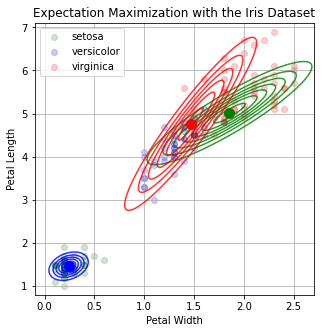

In [13]:
# Convert dataset to array for ease of meshgrid creation
X = np.array(train_data)

# Create Linear Space Matrix for Plotting Gaussians Mixtures
lin_x = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0]) + 0.2, 200)
lin_y = np.linspace(np.min(X[:,1])- 0.2, np.max(X[:,1])+0.2, 200)
ac, db = np.meshgrid(lin_x,lin_y)

# Initialize Plot
fig = plt.figure(figsize=(5,5))
ax0 = fig.add_subplot(111)

# Create color dictionaries & iterable
species = ['setosa','versicolor','virginica']
colors_1 = {0: 'green', 1:'blue', 2: 'red'}
colors_2 = {'setosa': 'green', 'versicolor':'blue', 'virginica': 'red'}

# Plot each species (original data) in a different color
for specie in species:
    temp = train_data_labeled[train_data_labeled['species'] == specie]
    ax0.scatter(temp['petal_width'], temp['petal_length'], label = specie, 
    c = colors_2[specie], alpha = 0.2)
ax0.legend()
ax0.grid()

# Iterate through the means and covariances and plot the Guassians
for i in range(len(means)):
    m = means[i]
    c = covs[i]
    multi_normal = multivariate_normal(mean=m,cov=c)
    pos = np.dstack((ac,db))
    ax0.contour(ac,db,multi_normal.pdf(pos), colors = colors_1[i], alpha = 0.8)
    ax0.scatter(m[0],m[1],c=colors_1[i],zorder=10,s=100)
    ax0.set_xlabel('Petal Width')
    ax0.set_ylabel('Petal Length')
plt.title("Expectation Maximization with the Iris Dataset")
plt.show()

Though our algorithm seems to be performing adequately in attempting to cluster our data, it is worth exploring other implementations and built-ins to check whether its performance is comparable to that of implementations compiled by other, more accomplished Data Scientists. 

### Compare to a pre-built Gaussian Mixture Model | sklearn
Here we will try to compare our output with **sklearn's GaussianMixture** built-in function. Please note that sklearn's Gaussian Mixture model initiates its parameters using one of the following ways: 

- Random
- KMeans (it will perform KMeans to determine where to initialize the means and covariances)

We will be testing the performance of both implementations below. The code for plotting will looking exactly like that above, so I will spare you a description of its steps. What follows below is a representation of the GaussianMixture built-in initialized with a random state. Please note again that the color assignment is random (as the location of the means within the output dataframe is random). The colors are aligned because I performed the plotting and calculation until they matched. 

Converged: True
Number of Iterations: 17


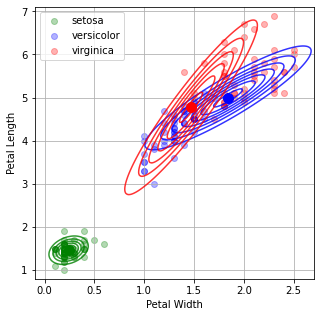

In [14]:
# Convert dataset to array for ease of meshgrid creation
X = np.array(train_data)

# Create meshgrid for plotting Gaussian Mixtures
lin_x = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0]) + 0.2, 200)
lin_y = np.linspace(np.min(X[:,1])- 0.2, np.max(X[:,1])+0.2, 200)
ac, db = np.meshgrid(lin_x,lin_y)

# Perform EM with built-in sklearn function
GMM = GaussianMixture(n_components = 3, init_params = 'random').fit(X)
print(f'Converged: {GMM.converged_}')
print(f'Number of Iterations: {GMM.n_iter_}')
means_skl = GMM.means_
covariances_skl = GMM.covariances_

# Initialize the plots
fig = plt.figure(figsize=(5,5))
ax0 = fig.add_subplot(111)

# Initialize color dictionary
colors = {'setosa': 'green', 
'versicolor':'blue', 
'virginica': 'red'}

colors_1 = {0: 'green', 
1:'blue',
2: 'red'}
species = ['setosa','versicolor','virginica']

# Plot each data point in assigned color
for specie in species:
    temp = train_data_labeled[train_data_labeled['species'] == specie]
    ax0.scatter(temp['petal_width'], temp['petal_length'], label = specie, 
    c = colors[specie], alpha = 0.3)
ax0.legend()
ax0.grid()

# Plot the contours using the
for i in range(len(means)):
    m = means_skl[i]
    c = covariances_skl[i]
    multi_normal = multivariate_normal(mean=m,cov=c)
    pos = np.dstack((ac,db))
    ax0.contour(ac,db,multi_normal.pdf(pos), colors = colors_1[i], alpha = 0.8)
    ax0.scatter(m[0],m[1],c=colors_1[i],zorder=10,s=100)
    ax0.set_xlabel('Petal Width')
    ax0.set_ylabel('Petal Length')
plt.show()

Using sklearn's Gaussian Mixture models with random initial parameters, we actually convergence to pretty much the exact same clustering as our model did! This was a very satisfying thing to see. However, it's worth having a look at the clustering model's performance when the initial parameters are created using KMeans. Having a look at how things change when incorporating different models within the one we have built is an interesting exercise and may prove fruitful in deciding which steps to take first when faced with a new analysis vertical. Please note again that the color assignment is random (as the location of the means within the output dataframe is random). The colors are aligned because I performed the plotting and calculation until they matched. 

Converged: True
Number of Iterations: 3


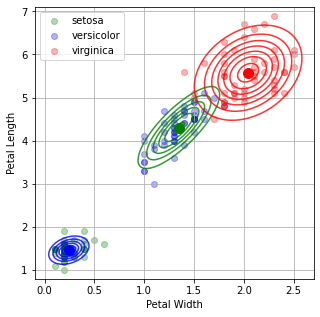

In [15]:
# Convert dataset to array for ease of meshgrid creation
X = np.array(train_data)

# Create meshgrid for plotting Gaussian Mixtures
lin_x = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0]) + 0.2, 200)
lin_y = np.linspace(np.min(X[:,1])- 0.2, np.max(X[:,1])+0.2, 200)
ac, db = np.meshgrid(lin_x,lin_y)

# Perform EM with built-in sklearn function
GMM = GaussianMixture(n_components = 3, init_params = 'kmeans').fit(X)
print(f'Converged: {GMM.converged_}')
print(f'Number of Iterations: {GMM.n_iter_}')
means_skl = GMM.means_
covariances_skl = GMM.covariances_

# Initialize the plots
fig = plt.figure(figsize=(5,5))
ax0 = fig.add_subplot(111)

# Initialize color dictionary
colors = {'setosa': 'green', 
'versicolor':'blue', 
'virginica': 'red'}

colors_1 = {0: 'green', 
1:'blue',
2: 'red'}
species = ['setosa','versicolor','virginica']

# Plot each data point in assigned color
for specie in species:
    temp = train_data_labeled[train_data_labeled['species'] == specie]
    ax0.scatter(temp['petal_width'], temp['petal_length'], label = specie, 
    c = colors[specie], alpha = 0.3)
ax0.legend()
ax0.grid()

# Plot the contours using the
for i in range(len(means)):
    m = means_skl[i]
    c = covariances_skl[i]
    multi_normal = multivariate_normal(mean=m,cov=c)
    pos = np.dstack((ac,db))
    ax0.contour(ac,db,multi_normal.pdf(pos), colors = colors_1[i], alpha = 0.8)
    ax0.scatter(m[0],m[1],c=colors_1[i],zorder=10,s=100)
    ax0.set_xlabel('Petal Width')
    ax0.set_ylabel('Petal Length')
plt.show()

When we employed KMeans to initialize the parameter, the clustering began to represent the data a lot more closely, as expected. When the initial means and covariances are initialized with parameters closer to the "truth", it is natural that EM would quickly arrive at a more efficient clustering. As a matter of fact, it's worth noting that, when using KMeans as initial parameters, the total number of iterations required to reach convergence went from ~30 to 3. 

This makes for an incredibly interesting and easy-to-comprehend visualization of the value and importance of the Data Scientist's decision-making. 